# Objective:
To Implent Stochastic Gradient Descent for Boston data from scratch and compare the MSE of it with SGDRegressor of sklearn and plot the target and predicted target variables.

In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import load_boston
from math import sqrt
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
# Lests store the design matrix in X and target variables in Y
X = load_boston().data
Y = load_boston().target

In [3]:
# Lets preprocess the design matrix using standardScaler of sklearn 
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

## Sklearn SGDRegressor:

#### Here I am not splitting the dataset into train and test data, As our main objective is to implement Stochacstic Gradient Descent from scratch and get similar or best Mean square error value than sklearn's SGDregressors but not building a predictive model. So particularly for this objective there is no data leakage issue, Thats why ignored train test split.

In [4]:
# Now lets fit the SGDRegressor to the whole design matrix and find the mean square error of our model.
clf = SGDRegressor()
clf.fit(X, Y)
print(mean_squared_error(Y, clf.predict(X)))

22.839888898000176


#### Observations:
- So Mean Square error with sklearn sgdregressor is 23.0459
- So we have to try to get atleast 23.0459 or less Mean Square error with our Gradient Descent as well.

In [62]:
print("weights of sklearn SGD regressor are")
print(clf.coef_)
print("\n")
print("intercept of Sklearn sgd regressor is")
print(clf.intercept_)

weights of sklearn SGD regressor are
[-0.6947907   0.45304257 -0.45254763  0.81677005 -1.02892204  3.1823722
 -0.13738301 -2.08661815  0.83307513 -0.53361707 -1.928435    0.93757519
 -3.44556926]


intercept of Sklearn sgd regressor is
[22.33960852]


In [5]:
# Lets add the intercept term to weights 
sklearn_sgd_weights = np.hstack((clf.coef_, clf.intercept_))

### Gradient Descent From scratch for linear regression model.

- Before we write our own gradient descent, we need initial weights which should be optimized.
- Lets derive the first weights from a normal distribution of mean 0 and standard deviation of 0.01

In [7]:
w = np.random.normal(scale=0.01, size=(X.shape[1], 1))
w = w.reshape(len(w))
#b = np.zeros(X.shape[1])

In [8]:
print(w)
w.shape, X.shape

[-0.01144135 -0.00225011  0.00413163  0.01230222 -0.01725211  0.01225382
  0.01494041 -0.00828239 -0.00176375 -0.01110636 -0.0126071  -0.00347164
  0.01358905]


((13,), (506, 13))

- AS we can see from above we have 13 weight values in w which is each weight for single feature.
- Here we will treat bias as also a weight, So if we treat bias also as a weight the bias weight should also have a feature.
- So for this, we will add a column of 1 to the design matrix, With adding of 1 column we now have total 14 features and 14 weights.

In [9]:
# Lets add a new column 1 for X, so that we cover bias too.
X_withb = np.hstack((X, np.full((len(X),1), fill_value=1)))

In [10]:
# As we have modified our X, lets regenerate initial weights again.
w = np.random.normal(scale=0.01, size=(X_withb.shape[1], 1))
w = w.reshape(len(w))
print(w)
w.shape, X_withb.shape

[-0.01067907 -0.00738676  0.00781648 -0.00251265  0.00762095 -0.01327984
 -0.00118962 -0.01451885  0.0043454   0.01089414 -0.00460794 -0.00036323
  0.00084132  0.01834275]


((14,), (506, 14))

- As we have weights, we know from linear regression we can predict target variables using,
$$\mathbf{Ypredict}= \mathbf{X} \mathbf{w} $$

In [11]:
pred_y = (np.dot(X_withb, w))

- Now lets calculate the mean square error between original target variables and predicted target variables.

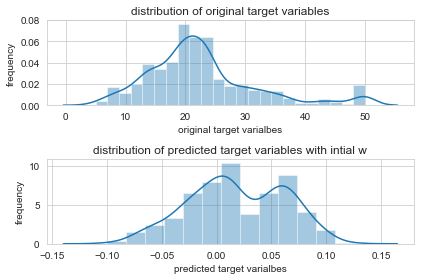

In [12]:
sns.set_style('whitegrid')
fig,axes= plt.subplots(2,1)
sns.distplot(Y, ax=axes[0])# label='predicted'
axes[0].set_title("distribution of original target variables")
axes[0].set(xlabel="original target varialbes", ylabel='frequency')
sns.distplot(pred_y, ax=axes[1])
axes[1].set_title("distribution of predicted target variables with intial w")
axes[1].set(xlabel="predicted target varialbes", ylabel='frequency')
plt.tight_layout()

In [13]:
mean_squared_error(Y, pred_y)

591.7556734581785

#### Observations:
- In the above plot original target variables ranges from 0 to 50.
- Whereas predicted values ranges only between -0.10 to 0.10.
- So our model with initial weights have preformend very poorly.
- This can also see in the mean square error, our model has mean square error of 592.87 whereas sklearn sgdregressor has only 23.04.
- Now lets implement the gradient descent using the initial weigts and try to reduced the Mean square error.

###  Gradient of the Mean square error loss function for linear regression is:

$$ L(w) = \frac{1}{2N}\sum_{n=1}^N(y_n - (Xw)_n+b)^2 $$

$$ \frac{\partial L}{\partial w_j} = -\frac{1}{N}\sum_{n=1}^N x_{nj}(y_n - (Xw)_n) = -\frac{1}{N}x_j^Te,$$

where xj is the jth column of X. Therefore, Gradient of a loss function wrt w is:
$$ \nabla L(w) = -\frac{1}{N}X^Te $$

#### Source: https://math.stackexchange.com/questions/1962877/compute-the-gradient-of-mean-square-error

In [14]:
# Lets write a function which outputs gradient of the loss function for linear regression.
def grad_loss(design_matrix, weights, targets):
    '''
       This funciton outputs gradient of the loss function for linear regression, given
       design_matrix = numpy ndimensiona array.
       weights = previous weight vector.
       target = original target variables
    '''
    error = (np.dot(design_matrix, weights)-targets)
    loss_gradient = (np.dot(np.transpose(design_matrix), error))/(len(design_matrix))
    return loss_gradient

$$ \nabla L(w) = -\frac{1}{N}X^Te $$
$$ Wnew = Wold - \gamma * \nabla L(w) $$

In [54]:
learning_rate = 0.12
updated_weight = w
for epoch in range(1000):
    # Taking only 100 samples from whole data
    samples = np.random.choice(X_withb.shape[0], 100, replace=False)
    next_w = updated_weight - learning_rate*grad_loss(design_matrix=X_withb[samples], weights=updated_weight, targets=Y[samples])
    updated_weight = next_w
    learning_rate = learning_rate
    #print(updated_weight)
    
    #print(next_w)
    #break
    #if abs((next_w-updated_weight) < 0.01).sum() == 0:
        

In [55]:
mean_squared_error(Y, np.dot(X_withb, updated_weight))

21.99763298425372

### Observations:
1. Our gradient descent with learning rate of 0.12 has done slightly better that sklearn sgdregressor.
2. Our model is getting 21.99 Mean square Error, while sklearns sgdregressor got 22.839, So for this particular boston data our model has less MSE.

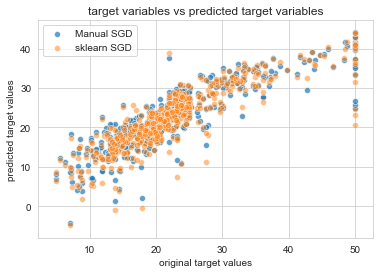

In [56]:
ax = sns.scatterplot(Y, np.dot(X_withb, updated_weight), alpha=0.7, label='Manual SGD');
sns.scatterplot(Y, clf.predict(X), alpha=0.5, label='sklearn SGD')
ax.set(xlabel='original target values', ylabel='predicted target values');
ax.set_title("target variables vs predicted target variables");

- We can clearly see positive corelation between original target values and predicted target values,
- So updated weights are much better than the previous initialised weights.
- From above visualization our model predicted target varialbe on par with sklearn sgdregressor.

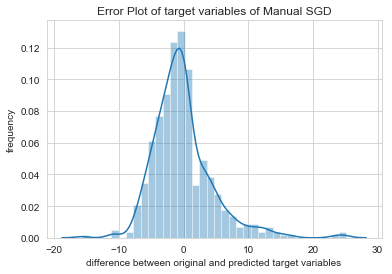

In [57]:
ax = sns.distplot(Y - np.dot(X_withb, updated_weight));
ax.set(xlabel='difference between original and predicted target variables', ylabel='frequency', title='Error Plot of target variables of Manual SGD');

- We can see most of the observations lies near zero, which is very good sign indicating predicted y values and original y values are near to zero.

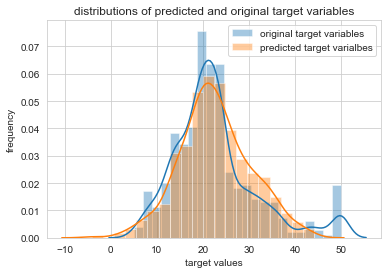

In [58]:
plt.Figure(figsize=(8,6))
sns.distplot(Y, label='original target variables')
sns.distplot(np.dot(X_withb, updated_weight), label='predicted target varialbes');
plt.legend()
plt.title("distributions of predicted and original target variables");
plt.xlabel("target values");
plt.ylabel("frequency");

- As we can see both the distributions or overlapping on each other.
- which indicates that our gradient descent algorithm did very good job in getting the optimal weights vector.

#### lets compare the weights of sklearn sgd and our manual weights.

In [59]:
pd.DataFrame({'sklearn sgd weights':sklearn_sgd_weights, 'manual sgd optimum weights':updated_weight})

,sklearn sgd weights,manual sgd optimum weights
0,-0.694791,-1.018099
1,0.453043,1.073171
2,-0.452548,0.211437
3,0.816770,0.656410
4,-1.028922,-2.093637
5,3.182372,2.534093
6,-0.137383,0.079941
7,-2.086618,-3.212094
8,0.833075,2.786614
9,-0.533617,-2.012552


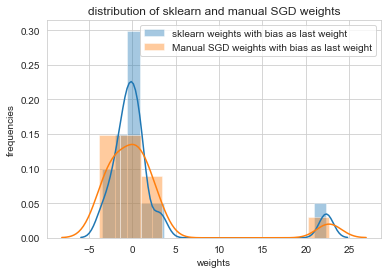

In [60]:
ax = sns.distplot(sklearn_sgd_weights, label='sklearn weights with bias as last weight');
sns.distplot(updated_weight, label='Manual SGD weights with bias as last weight');
ax.set(xlabel='weights', ylabel='frequencies', title='distribution of sklearn and manual SGD weights');
plt.legend();

- From above graphs both the weights of sklearn and manual sgd's are ranging from -5 to -5.
- Also both the distributions are overlapping on each other, which clearly shows the simialar performance on mean square error that we got.
- In both the distributions we can see there are bumps at the end near 22, which was caused due to bias.
- So both the sklearn sgd and manual sgd has taken approx same bias that is 22.33 and 22.66

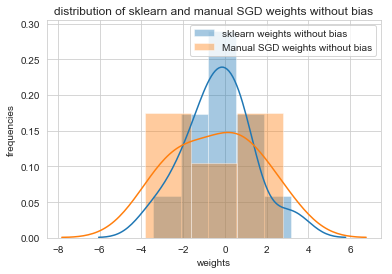

In [61]:
ax = sns.distplot(sklearn_sgd_weights[:-1], label='sklearn weights without bias');
sns.distplot(updated_weight[:-1], label='Manual SGD weights without bias');
ax.set(xlabel='weights', ylabel='frequencies', title='distribution of sklearn and manual SGD weights without bias');
plt.legend();

- So all the observations above holds true for this graph, as this graph is same as above but without bias.

### Conclusion:
1. Applied sklearn sgdregressor to boston data(design matrix), and predicted the target price with a mean square error of 22.839.
2. Implemented own stochachistic gradient descent for linear regression and got the optimal weights.
3. For manual stochastic gradient descent considered bias as one of the weight.
4. We got optimal weights with learning rate 0.12, and mean square error with optimal weights is 21.99.
5. After that analysed the weights of sgd regressor with the manual SGD weights and found that both the distributions are mostly overlapping, which indicated our manual SGD for linear regression on this data set is performing on par with sklearn sgd regressor.